<a href="https://colab.research.google.com/github/MaximilianoAdaro/ubicar-ml/blob/newBranch/MaxiLocal_AlgoDynamic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
runningWithColab = False

In [75]:
if runningWithColab:
  from google.colab import drive
  drive.mount('/content/drive')

In [76]:
if runningWithColab:
  !pip install -q condacolab -q #por alguna razon hay que correr esto que hacer tardar 10mins... idk
  import condacolab
  condacolab.install()
  !conda install geopandas

In [77]:
!pip install geopandas
!pip install rtree
!pip install pygeos
!pip install pyshp
!pip install matplotlib

In [78]:
import geopandas as gpd
import numpy as np
from geopandas import GeoDataFrame
import pandas as pd
import pyproj
from shapely.ops import linemerge, unary_union, polygonize, transform
from shapely.geometry import LineString, Polygon, Point, box, shape
from functools import partial
from matplotlib import pyplot as plt
from pyproj import Geod
from shapely import wkt, affinity

In [79]:
shapePath = "~/Downloads/ubicar/dynamic/polygon.shp"
propsPath = "~/Downloads/ubicar/dynamic/maxi-data-final.csv"

In [80]:
shapeDF = gpd.read_file(shapePath)
propsDf = pd.read_csv(propsPath) 

#shapeDF = gpd.read_file("drive/MyDrive/Ubicar/ShapeFiles/Simplified/polygon.shp")
#propsDf = pd.read_csv('drive/MyDrive/Ubicar/CSV data/newData/maxi-data-final.csv') 

In [81]:
shapeDF.type

0    Polygon
dtype: object

In [82]:
plot = False

if (plot):
  import shapefile as shp  # Requires the pyshp package
  import matplotlib.pyplot as plt

  sf = shp.Reader(shapePath)

  plt.figure()
  for shape in sf.shapeRecords():
      x = [i[0] for i in shape.shape.points[:]]
      y = [i[1] for i in shape.shape.points[:]]
      plt.plot(x,y)
  plt.show()

In [83]:
if plot:
  import shapefile as shp  # Requires the pyshp package
  import matplotlib.pyplot as plt

  sf = shp.Reader(shapePath)

In [84]:
propsDf['priceM2'] = propsDf.apply(lambda row: row.price/ row.surface_total, axis=1)

In [85]:
propsDf[propsDf['priceM2'] < 30]

,Unnamed: 0,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,dTrainStation,dUniversity,departamento_id,departamento_nombre,municipio_id,municipio_nombre,provincia_id,provincia_nombre,dSubway,priceM2
37425,11389,rmHp7ad/j1FlFizjBUWv1g==,2020-11-21,2020-12-02,2020-11-21,-31.493757,-64.568710,Argentina,Córdoba,Punilla,...,20791.796517,34971.709211,14091,Punilla,142546.0,Villa Río Icho Cruz,14,Córdoba,NaN,23.650794
112235,70094,ld3akTBeZXUg3tEMaYSVSg==,2020-06-27,2020-07-02,2020-06-27,-31.692425,-64.414586,Argentina,Córdoba,Santa María,...,5258.401334,32289.413363,14147,Santa María,142987.0,Anisacate,14,Córdoba,NaN,27.222222
121902,81935,AA8p2Rz/e/oMAtpUUk1aig==,2021-03-10,2021-06-05,2021-03-10,-34.594247,-58.397759,Argentina,Capital Federal,Recoleta,...,1544.287984,390.525678,2014,Comuna 2,NaN,NaN,2,Ciudad Autónoma de Buenos Aires,885.431097,23.051867
121903,124117,zfIJR+/46uZA1DD/bv0EYw==,2021-03-10,2021-06-05,2021-03-10,-34.594247,-58.397759,Argentina,Capital Federal,Recoleta,...,1544.287984,390.525678,2014,Comuna 2,NaN,NaN,2,Ciudad Autónoma de Buenos Aires,885.431097,23.051867
150102,123378,DTvEI4FVhcZpuTQYfHbWEg==,2020-06-07,2021-04-09,2020-06-07,-24.773918,-65.390045,Argentina,Salta,Salta,...,3262.185093,2614.010046,66028,Capital,660063.0,Salta,66,Salta,NaN,22.401210


In [86]:
geometry = [Point(xy) for xy in zip(propsDf.lon, propsDf.lat)]
propsGDF = GeoDataFrame(propsDf, crs="EPSG:4326", geometry=geometry) #GeoDataframe de las properties EPSG:4326 = ej -> -34, -54

In [87]:
propsGDF.to_crs(epsg=3857,inplace=True) #lo convertimos a 3857. (misma transformacion que nuestro shape polygon, sirve para calcular el area)

In [88]:
propsGDF['geometry']

0         POINT (-6505503.561 -4104893.694)
1         POINT (-6505503.561 -4104893.694)
2         POINT (-6505503.561 -4104893.694)
3         POINT (-6527839.160 -4107388.383)
4         POINT (-6506143.671 -4110609.678)
                        ...                
191070    POINT (-6506341.118 -4114213.836)
191071    POINT (-6498823.572 -4108832.001)
191072    POINT (-6498871.815 -4109828.457)
191073    POINT (-6501011.931 -4107394.373)
191074    POINT (-6499615.584 -4109143.234)
Name: geometry, Length: 191075, dtype: geometry

In [89]:
shapeDF

,geometry
0,"POLYGON ((-5777254.92149 -2724541.80841, -7479..."



#Division algo:

1- Definir minima area para los poligonos.

2- Por cada poligono, es decir por cada provincia, calcular primero el precio de m^2 (lat-long)

3-  hacer un split random del poligono y comparar el m^2 de los nuevos splits.

In [108]:
def cut_polygon_by_line(polygon, line): #cortamos el polygono.
    merged = linemerge([polygon.boundary, line])
    borders = unary_union(merged)
    polygons = polygonize(borders)
    return list(polygons)

def plot(shapely_objects, figure_path='fig.png'): #Para plotear las casas
    from matplotlib import pyplot as plt
    import geopandas as gpd
    boundary = gpd.GeoSeries(shapely_objects)
    boundary.plot(color=['red', 'green', 'blue', 'yellow', 'yellow','red', 'green', 'blue', 'yellow', 'yellow','red', 'green', 'blue', 'yellow', 'yellow'])
    plt.show()
    #plt.savefig(figure_path)

def calculateArea(gdf):
  gdf.to_crs(epsg=3395,inplace=True)
  return gdf.area[0]/ 10**6

def calculateAreainRespectToParent(parentShape,shapeAfterCut):
  gdfpoly1 = GeoDataFrame(geometry=[parentShape], crs="EPSG:3857")
  gdfpoly2 = GeoDataFrame(geometry=[shapeAfterCut], crs="EPSG:3857")
  AParent = calculateArea(gdfpoly1)
  ACut = calculateArea(gdfpoly2)
  res = (ACut * 100 / AParent)
  #print("res ",res)

  if( ACut * 100 / AParent < 25): #Si por lo menos contiene un 25% respecto al padre, va
    return True
  else:
    return False  
  

def polyFn(shape,resultingPolys,n,df_busqueda):
  #minx, miny, maxx, maxy = list(shape.bounds)
  #line = LineString([ Point(minx, (miny+maxy)/2), Point(maxx,(miny+maxy)/2)])   
  
  plot(shape)
  exteriorCoords = list(shape.exterior.coords) #each of this is a vertex point. So, our lines will have to start from this point towards another point.
  print(f"Exterior coords amount: {len(exteriorCoords)}")
  #We assign this first.
  maxX = exteriorCoords[0][0]
  maxY = exteriorCoords[0][1]
  minX = exteriorCoords[0][0]
  minY = exteriorCoords[0][1]

  for coords in exteriorCoords:
    if(coords[0] > maxX):
      maxX=coords[0]
    if(coords[1] > maxY):
      maxY=coords[1]
    if(coords[0] < minX):
      minX=coords[0]
    if(coords[1] < minY):
      minY=coords[1]

  #we assigned the maxiumum left and right, top and bottom vertices. So our cuts will be from the left to the top right, and from the bottom to top.

  for coords in exteriorCoords: #a partir de cada vertice tenemos que hacer n cortes
  #Tenemos que calcular hacia que lado debemos partir el poligono, si la coordenada que estamos esta a la derecha del resto de las coordenadas, tenemos que splitear hacia la izquierda.
  #La altura maxima tambien debemos calcular ya que queremos que cambie la altura del corte. Si esta arriba tiene que cortar hacia abajo, o si esta abajo hacia arriba.

    valuesX = list(np.linspace(minX, maxX, num=n, endpoint=True)) #calculamos los valores de X
    valuesY = list(np.linspace(minY, maxY, num=n, endpoint=True)) #calculamos los valores de Y

    totalHousesInPoly, totalM2, df_busqueda_update = getHousesInPoly(shape, df_busqueda)
    pointCoords = Point(coords[0], coords[1])

    if(totalHousesInPoly > 20):
      for i in range(n): #hacemos n cortes desde cada vertice
        if(coords[1] == minY and coords[0] != minX and coords[0] !=maxX):
          #if we cut from left to right and are in the bottom.
          line = LineString([pointCoords, Point(valuesX[i],maxY)])
          print("Cut 1")
        
        elif(coords[1] == maxY and coords[0] != minX and coords[0] !=maxX):
          #if we cut from left to right and are in the top.
          line = LineString([pointCoords, Point(valuesX[i],minY)])
          print("Cut 2")
        
        elif(coords[0] == minX and coords[1] != minY and coords[1] !=maxY):
          #if we cut from top to bottom and are in the left.
          line = LineString([pointCoords, Point(maxX,valuesY[i])])
          print("Cut 3")

        elif(coords[0] == maxX and coords[1] != minY and coords[1] !=maxY):
          #if we cut from top to bottom and are in the right.
          line = LineString([pointCoords, Point(minX,valuesY[i])])
          print("Cut 4")

        else:
          #we shouldn't reach here but just in case, we cut by the diagonal
          minx, miny, maxx, maxy = list(shape.bounds)
          line = LineString([ Point(minx, (miny+maxy)/2), Point(maxx,(miny+maxy)/2)])
          print("Cut 5")

        split = cut_polygon_by_line(shape, line) #Here comes the remaining polygons after the split, so split=[polys] which together form 'shape'
        if(calculateAreainRespectToParent(shape,split[0])): #If we have somewhat a good cut.
          plot(split)
          for poly in split: #remaining polygons after cut.
            totalHousesAfterSplit, totalAfterSplitM2, df_busqueda_update_2 = getHousesInPoly(poly, df_busqueda_update) #Calculate totalhousesAfterSplit, and totalM2AfterSplit (in a splitted polygon)
            gdfpoly = GeoDataFrame(geometry=[poly], crs="EPSG:3857")
            area=calculateArea(gdfpoly)
            #print('area: ', area)
            #print(df_busqueda_update_2)
            if(totalHousesAfterSplit >= 20 or area >= 1.0): #If we have atleast 20 houses, or the area is greater= than 1
              totalPercentageInPoly = totalHousesAfterSplit/totalHousesInPoly*100 #We get the percentage of houses in polygon
              if (calculateError(df_busqueda_update_2,df_busqueda_update)): #calculamos si el error es mejor o no, si no lo es seguimos iterando
                resultingPolys.append([poly,totalAfterSplitM2])# save the poly and the m2
                break;
              else:
                polyFn(poly,resultingPolys,n,df_busqueda_update_2) #we have a meh polygon, keep splitting it.
            else:
              resultingPolys.append([shape,totalM2]) #add the parent poly.
        else:
          break; #bad cut, dont add and break loop.

      
def calculateError(df_HousesAfterSplit,df_HousesInParentPolygon):
  #Maxi error_calculation finding?
  #meanM2AfterSplit = getTotalM2(df_HousesAfterSplit)
  #meanM2BeforeSplit = getTotalM2(df_HousesInParentPolygon)

  std_error_before = np.std(df_HousesInParentPolygon['priceM2'], ddof=1) / np.sqrt(np.size(df_HousesInParentPolygon['priceM2'])) # stdeviation del promedio de m2 / raiz(tamano de la cantidad de casas en ese promedio)
  std_error_after = np.std(df_HousesAfterSplit['priceM2'], ddof=1) / np.sqrt(np.size(df_HousesAfterSplit['priceM2'])) # stdeviation del promedio de m2 / raiz(tamano de la cantidad de casas en ese promedio)

  #print("eB ",std_error_before)
  #print("eA ",std_error_after)

  if (std_error_before >= std_error_after): 
    return True #Error se reduce
  else: 
    return False # error no se reduce, Seguimos iterando

def getTotalM2(df):
  size = len(df)
  meanM2 = df['priceM2'].sum()/size
  return meanM2

def getHousesInPoly(poly, df_busqueda): 
  polygpd = GeoDataFrame(geometry=[poly], crs="EPSG:3857")
  joined = gpd.sjoin(df_busqueda,polygpd,how='left',predicate='within') #here we join the new df_busqueda with the poly if its within.
  joined = joined[joined['index_right'].notna()] #drop those that are not within
  joined.drop(['index_right'], axis=1, errors='ignore',inplace=True) #drop the added col so we can repeat the process
  size = len(joined)

  if(size >= 1):
    print(f"size {size}")
    meanM2 = joined['priceM2'].sum()/size
    #print(meanM2)
  else:
    meanM2 = 0
  return size, meanM2, joined


def setM2ForHousesInPoly(polyArray):
    poly = polyArray[0]
    m2 = polyArray[1]
    for j, pt in propsGDF.iterrows():
        if poly.contains(pt.geometry):
            propsGDF.loc[j, 'nearestM2'] = m2 # this is to set so we have to do itterrows...

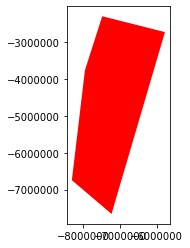

In [109]:
plot(shapeDF.iloc[0].geometry)

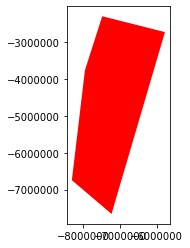

Exterior coords amount: 6
size 191075
Cut 4
size 191075
Cut 2


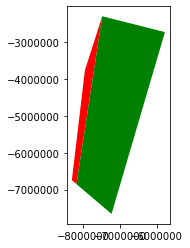

size 939


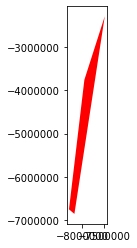

Exterior coords amount: 5
size 939
Cut 5
size 939
Cut 1
size 939
Cut 3


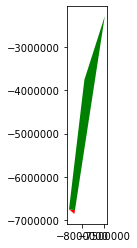

size 0


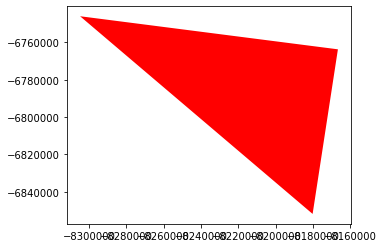

Exterior coords amount: 4
size 0
size 0
size 0
size 0
size 939
Cut 3


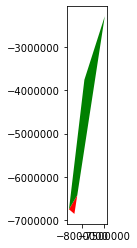

size 0


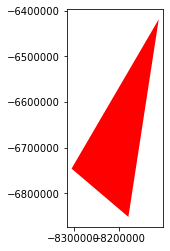

Exterior coords amount: 4
size 0
size 0
size 0
size 0
size 939
Cut 3


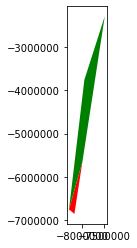

size 0


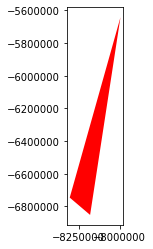

Exterior coords amount: 4
size 0
size 0
size 0
size 0
size 939
Cut 3
size 939
Cut 5
size 939
Cut 5
size 190136


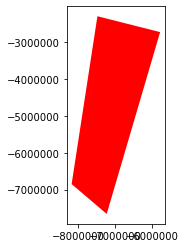

Exterior coords amount: 5


KeyboardInterrupt: ignored

In [107]:
polyArray = [] #we need to save all the polygons as a tuple

#for pos, poly in shapeDF.iterrows():
#  minx, miny, maxx, maxy = list(poly.geometry.bounds)
 # line = LineString([ Point(minx, miny), Point(maxx,maxy)]) #se splitea por una linea diagonal (este es el primer split)
  #result = cut_polygon_by_line(poly.geometry, line)

polyFn(shapeDF.iloc[0].geometry,polyArray,4, propsGDF) 

#npArray = np.array(polyArray)
#with open('/Downloads/ubicar/dynamic/array.txt', 'w') as f:
#    np.savetxt(f, npArray)

propsGDF['nearestM2'] = np.nan
for poly in polyArray:
  setM2ForHousesInPoly(poly)

propsDf = pd.DataFrame(propsGDF.drop(columns=['geometry','priceM2']))


In [94]:
propsDf.to_csv('~/Downloads/ubicar/dynamic/PostAlgoCasas.csv', index=False) #Despues con este se hace el entrenado del modelo.

In [95]:
propsDf.describe()

,Unnamed: 0,lat,lon,rooms,surface_total,surface_covered,price,dRailway,dIndustrialArea,dAirport,...,dPenitentiary,dPort,dSecureBuilding,dTrainStation,dUniversity,departamento_id,municipio_id,provincia_id,dSubway,nearestM2
count,191075.000000,191075.000000,191075.000000,191075.000000,191075.000000,191075.00000,191075.000000,191075.000000,191075.000000,191075.000000,...,191075.000000,191075.000000,191075.000000,191075.000000,191075.000000,191075.000000,87540.000000,191075.000000,85473.000000,1.910750e+05
mean,103435.758817,-34.430859,-59.033315,2.953400,116.742410,88.05277,174010.598320,1918.942947,13270.694058,17798.754069,...,33458.442153,36191.113749,1772.236922,2423.202992,2724.466096,13074.278409,117924.817443,12.818391,1062.836822,1.898096e+03
std,59680.673173,1.229128,1.835340,1.489012,115.944604,63.31283,129323.154607,6859.487059,16947.894318,11335.007991,...,76848.864659,103451.254613,4371.583958,6543.795778,6542.331517,24000.129378,178406.661843,24.048536,1042.637496,2.273743e-13
min,1.000000,-41.986706,-71.686300,1.000000,20.000000,11.00000,10500.000000,0.011708,0.000000,136.785058,...,49.205164,28.399874,6.778779,7.822090,1.975269,2007.000000,60028.000000,2.000000,2.482115,1.898096e+03
25%,51742.500000,-34.630100,-58.649794,2.000000,50.000000,44.00000,85000.000000,451.873150,7408.050271,11701.482987,...,13682.455773,5810.029329,630.357228,871.282280,572.923803,2084.000000,60427.000000,2.000000,381.303562,1.898096e+03
50%,103510.000000,-34.590028,-58.472648,3.000000,75.000000,66.00000,135000.000000,992.026127,12047.091045,17329.275244,...,18296.060748,10898.419572,1013.661224,1486.916426,1189.704686,6270.000000,60638.000000,6.000000,713.383245,1.898096e+03
75%,155114.500000,-34.499624,-58.414637,4.000000,138.000000,110.00000,220000.000000,1750.238150,15110.066263,21525.518316,...,22641.118315,21571.712343,1548.304578,2326.467372,2334.751078,6756.000000,60805.000000,6.000000,1316.965813,1.898096e+03
max,206751.000000,-24.659769,-55.874782,14.000000,955.000000,397.00000,791500.000000,191859.002829,208886.178863,243819.378525,...,588603.895041,951927.365324,128069.736867,145539.833034,193012.286019,90119.000000,908644.000000,90.000000,7035.899830,1.898096e+03


In [21]:
propsDf['nearestM2']

0         1898.095546
1         1898.095546
2         1898.095546
3         1898.095546
4         1898.095546
             ...     
191070    1898.095546
191071    1898.095546
191072    1898.095546
191073    1898.095546
191074    1898.095546
Name: nearestM2, Length: 191075, dtype: float64

In [ ]:
propsDf.to_csv('Downloads/ubicar/dynamic/PostAlgoCasas_2.csv',index=False) #Despues con este se hace el entrenado del modelo.